# Team 10 Project on Food Desert 

### Goal 

Goal of this notebook is to calculate the food desert for all census tracts in the United States using two main datasets: 

1) The USDA 2010 Food Desert dataset, which contains flags about food desert and demographic information at the census tract level 

2) Census estimates for 2019, which contains demographic information at the census tract level based on population estimates

In [1]:
%matplotlib inline 

import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns 
import scipy.stats as stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## Part 1: USDA Dataset 2015

In [2]:
# read csv file accidents.csv 
df = pd.read_csv('fooddesert.csv')
print(df.head())
print(df.shape)

   CensusTract    State   County  Urban  POP2010  OHU2010  GroupQuartersFlag  \
0   1001020100  Alabama  Autauga      1     1912      693                  0   
1   1001020200  Alabama  Autauga      1     2170      743                  0   
2   1001020300  Alabama  Autauga      1     3373     1256                  0   
3   1001020400  Alabama  Autauga      1     4386     1722                  0   
4   1001020500  Alabama  Autauga      1    10766     4082                  0   

   NUMGQTRS  PCTGQTRS  LILATracts_1And10  ...  TractSeniors  TractWhite  \
0         0  0.000000                  0  ...           221        1622   
1       181  0.083410                  0  ...           214         888   
2         0  0.000000                  0  ...           439        2576   
3         0  0.000000                  0  ...           904        4086   
4       181  0.016812                  0  ...          1126        8666   

   TractBlack  TractAsian  TractNHOPI  TractAIAN  TractOMultir  Trac

### Tracts that have a population of 0 

Some tracts have a total population value of 0. This analysis will exclude census tracts that have a population value that is equals to 0.

In [3]:
# filter out tracts that have a population size of 0 
df = df[df['POP2010'] > 50]
df.shape

(72337, 147)

### Replacing 0 vals by 1 for race variables

To calculate the entropy index we don't want to have 0 values, because we need to multiply by the natural log for each race proportion. To avoid this issue, here I replace every 0 value for any given population by 1. After testing in the first iteration of this calculation, replacing 0s by 1s in the raw number (NOT in the proportions), did not cause any issues or any changes in the proportions. 

#### First, create instance of the dataframe with only race values of interest, and keep the same CensusTract as index, and replace 0s for 1s for this subset of the original dataframe

In [4]:
# replace 0 race vals by 1 
df_race = df[['TractWhite', 'TractBlack','TractAsian','TractNHOPI','TractAIAN',
                'TractOMultir','TractHispanic']].replace(0,1) # replace 0 values by 1 

# see any columns that have value of 0 for race 
df_race.columns[(df_race == 0).any()] # no cols --good 

Index([], dtype='object')

#### Second, merge df_race with the original df, to include new values for the race variables, which will have _y as suffix

In [5]:
# merging updated race df with original dataframe
df_all = pd.merge(df, df_race, how='inner', left_on=None, right_on=None,
         left_index=True, right_index=True)

df_all.head(2)

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractHispanic_x,TractHUNV,TractSNAP,TractWhite_y,TractBlack_y,TractAsian_y,TractNHOPI_y,TractAIAN_y,TractOMultir_y,TractHispanic_y
0,1001020100,Alabama,Autauga,1,1912,693,0,0,0.00000,0,...,44,26,112,1622,217,14,1,14,45,44
1,1001020200,Alabama,Autauga,1,2170,743,0,181,0.08341,0,...,75,87,202,888,1217,5,1,5,55,75


#### Third, create a total population variable which adds up all of the different race variables with _y as suffix

In [6]:
# create population variable, because the pop2010 var has discrepancies with totals 
df_all['totalpop'] = df_all['TractWhite_y'] + df_all['TractBlack_y'] + df_all['TractAsian_y'] + df_all['TractNHOPI_y'] + df_all['TractAIAN_y'] + df_all['TractOMultir_y'] + df_all['TractHispanic_y']
df_all.head()

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractHUNV,TractSNAP,TractWhite_y,TractBlack_y,TractAsian_y,TractNHOPI_y,TractAIAN_y,TractOMultir_y,TractHispanic_y,totalpop
0,1001020100,Alabama,Autauga,1,1912,693,0,0,0.000000,0,...,26,112,1622,217,14,1,14,45,44,1957
1,1001020200,Alabama,Autauga,1,2170,743,0,181,0.083410,0,...,87,202,888,1217,5,1,5,55,75,2246
2,1001020300,Alabama,Autauga,1,3373,1256,0,0,0.000000,0,...,108,120,2576,647,17,5,11,117,87,3460
3,1001020400,Alabama,Autauga,1,4386,1722,0,0,0.000000,0,...,19,82,4086,193,18,4,11,74,85,4471
4,1001020500,Alabama,Autauga,1,10766,4082,0,181,0.016812,0,...,198,488,8666,1437,296,9,48,310,355,11121


### Calculating proportions by race

Now that we have the correct numbers, we can calculate the proportion by race using the calculated total population variable and each race variable with _y as suffix.

In [7]:
# create new columns with the proportion of race
df_all['prop_white']  = df_all['TractWhite_y']/df_all['totalpop']
df_all['prop_black']  = df_all['TractBlack_y']/df_all['totalpop']
df_all['prop_asian']  = df_all['TractAsian_y']/df_all['totalpop']
df_all['prop_hisp']   = df_all['TractHispanic_y']/df_all['totalpop']
df_all['prop_nhopi']  = df_all['TractNHOPI_y']/df_all['totalpop']
df_all['prop_aian']   = df_all['TractAIAN_y']/df_all['totalpop']
df_all['prop_multir'] = df_all['TractOMultir_y']/df_all['totalpop']

# create total prop variable 
df_all['totalprop'] = df_all['prop_white'] + df_all['prop_black'] + df_all['prop_asian'] + df_all['prop_hisp'] + df_all['prop_nhopi'] + df_all['prop_aian'] + df_all['prop_multir']

# check that all proportions add up to 1 
df_all['totalprop'].value_counts()

1.0    50526
1.0    14917
1.0     5414
1.0     1470
1.0        9
1.0        1
Name: totalprop, dtype: int64

## Creating the entropy index AKA diversity index AKA Thiels' H score

For more information on diversity index, check the following resource: 

The maximum score for entropy index is the natural log of the total number of racial groups. In this case ln(7) = 1.94

In [8]:
# create entropy index 
df_all['entropy_index15'] = -(df_all['prop_white']*np.log(df_all['prop_white']) + 
                        df_all['prop_black']*np.log(df_all['prop_black']) +  
                        df_all['prop_hisp']*np.log(df_all['prop_hisp']) + 
                        df_all['prop_asian']*np.log(df_all['prop_asian']) +
                        df_all['prop_aian']*np.log(df_all['prop_aian']) +
                        df_all['prop_multir']*np.log(df_all['prop_multir']) + 
                        df_all['prop_nhopi']*np.log(df_all['prop_nhopi'])
                      )
# view first obs
df_all.head(4)

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,totalpop,prop_white,prop_black,prop_asian,prop_hisp,prop_nhopi,prop_aian,prop_multir,totalprop,entropy_index15
0,1001020100,Alabama,Autauga,1,1912,693,0,0,0.00000,0,...,1957,0.828820,0.110884,0.007154,0.022483,0.000511,0.007154,0.022994,1.0,0.646102
1,1001020200,Alabama,Autauga,1,2170,743,0,181,0.08341,0,...,2246,0.395370,0.541852,0.002226,0.033393,0.000445,0.002226,0.024488,1.0,0.933888
2,1001020300,Alabama,Autauga,1,3373,1256,0,0,0.00000,0,...,3460,0.744509,0.186994,0.004913,0.025145,0.001445,0.003179,0.033815,1.0,0.794171
3,1001020400,Alabama,Autauga,1,4386,1722,0,0,0.00000,0,...,4471,0.913890,0.043167,0.004026,0.019011,0.000895,0.002460,0.016551,1.0,0.404433


In [9]:
# sort df by entropy values and check whether any value is null 
df_sorted = df_all.sort_values(by = 'entropy_index15', ascending = False)

# if any null value, it means the replacement of raw numbers hasn't occurred 
df_sorted[df_sorted['entropy_index15'].isnull()]

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,totalpop,prop_white,prop_black,prop_asian,prop_hisp,prop_nhopi,prop_aian,prop_multir,totalprop,entropy_index15


In [10]:
df_sorted.head()

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,totalpop,prop_white,prop_black,prop_asian,prop_hisp,prop_nhopi,prop_aian,prop_multir,totalprop,entropy_index15
1191,2020000600,Alaska,Anchorage,1,7747,2338,0,497,0.064154,0,...,8668,0.242386,0.123327,0.156437,0.106253,0.077065,0.149631,0.144901,1.0,1.891715
1197,2020000901,Alaska,Anchorage,1,4906,1536,0,753,0.153485,0,...,5470,0.310603,0.115722,0.095612,0.103108,0.042413,0.187569,0.144973,1.0,1.799364
1195,2020000801,Alaska,Anchorage,1,7323,2487,0,117,0.015977,0,...,8175,0.359388,0.094190,0.138104,0.104220,0.062018,0.098838,0.143242,1.0,1.778897
69951,53033028100,Washington,King,1,2477,822,0,32,0.012919,0,...,2938,0.260381,0.204901,0.182097,0.156909,0.040504,0.013274,0.141933,1.0,1.740297
8617,6067006500,California,Sacramento,1,6637,1873,0,26,0.003917,1,...,8456,0.206362,0.206362,0.147824,0.215114,0.026845,0.012181,0.185312,1.0,1.727662


# 2010 USDA Data

We use this dataset to get the USDA flag.

In [11]:
# read csv file accidents.csv 
df10a = pd.read_csv('2010fooddesert.csv')
#print(df10a.head())
print(df10a.shape)

(72864, 65)


### Tracts that have a population of 0 

Some tracts have a total population value of 0. This analysis will exclude census tracts that have a population value that is equals to 0.

In [12]:
# filter out tracts that have a population size of 0 
df10b = df10a[df10a['POP2010'] > 50]
df10b.shape

(72337, 65)

# Part 2: Census tract data 2010

Now that we have the 2015 entropy indexes, we will calculate the 2010 entropy indexes based on the population estimates from census tract.

Variables examples and list: https://api.census.gov/data/2019/acs/acs5/examples.html, https://api.census.gov/data/2019/acs/acs5/variables.html

Datacamp tutorial: https://www.youtube.com/watch?v=l47HptzM7ao&ab_channel=DataCamp

#### First, API call to get the dataset

In [13]:
states1 = pd.read_csv('https://raw.githubusercontent.com/kathiavf16/DS4A-Team-10/main/data%20by%20state/states_1_to_12.csv')
states2 = pd.read_csv('https://raw.githubusercontent.com/kathiavf16/DS4A-Team-10/main/data%20by%20state/states_13_to_25.csv')
states3 = pd.read_csv('https://raw.githubusercontent.com/kathiavf16/DS4A-Team-10/main/data%20by%20state/states_26_to_38.csv')
states4 = pd.read_csv('https://raw.githubusercontent.com/kathiavf16/DS4A-Team-10/main/data%20by%20state/2010%20States%2039-50.csv')

# concatenate states
upd = pd.concat([states1, states2, states3, states4])

# view first 5 obs 
upd.head()

,Unnamed: 0,geo_id,state,NAME,est_total,race_total,race_hisp,race_white,race_black,race_aian,race_asian,race_nhopi,race_other,race_multi1,race_multi2,race_multi3,state.1,county,tract
0,0,1400000US02122001000,2,"Census Tract 10, Kenai Peninsula Borough, Alaska",4143,4143,216,3636,13,190,21,5,3,59,18,41,2,122,1000
1,1,1400000US02122001100,2,"Census Tract 11, Kenai Peninsula Borough, Alaska",3007,3007,41,2754,0,74,75,0,0,63,0,63,2,122,1100
2,2,1400000US02122001200,2,"Census Tract 12, Kenai Peninsula Borough, Alaska",851,851,9,370,5,410,10,0,0,47,0,47,2,122,1200
3,3,1400000US02122001300,2,"Census Tract 13, Kenai Peninsula Borough, Alaska",5707,5707,386,3763,76,918,252,13,0,299,0,299,2,122,1300
4,4,1400000US02130000100,2,"Census Tract 1, Ketchikan Gateway Borough, Alaska",3349,3349,151,2895,0,138,69,0,17,79,0,79,2,130,100


In [14]:

# get censustract from geo_id, to match 2010 data
upd['census_tract'] = upd['geo_id'].str.slice(9, 20) 

# since some cols were read as objects instead of ints, need to update types -- this could be optimized 
upd['est_total'] = upd['est_total'].astype(int)
upd['race_total'] = upd['race_total'].astype(int)
upd['race_hisp'] = upd['race_hisp'].astype(int)
upd['race_white'] = upd['race_white'].astype(int)
upd['race_black'] = upd['race_black'].astype(int)
upd['race_aian'] = upd['race_aian'].astype(int)
upd['race_asian'] = upd['race_asian'].astype(int)
upd['race_nhopi'] = upd['race_nhopi'].astype(int)
upd['race_other'] = upd['race_other'].astype(int)
upd['race_multi1'] = upd['race_multi1'].astype(int)
upd['race_multi2'] = upd['race_multi2'].astype(int)
upd['race_multi3'] = upd['race_multi3'].astype(int)
upd['census_tract'] = upd['census_tract'].astype(int)

# set census_tract as index
upd = upd.set_index('census_tract')

#  check data types
upd.info()

print(upd.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64300 entries, 2122001000 to 50027966700
Data columns (total 19 columns):
Unnamed: 0     64300 non-null int64
geo_id         64300 non-null object
state          64300 non-null int64
NAME           64300 non-null object
est_total      64300 non-null int64
race_total     64300 non-null int64
race_hisp      64300 non-null int64
race_white     64300 non-null int64
race_black     64300 non-null int64
race_aian      64300 non-null int64
race_asian     64300 non-null int64
race_nhopi     64300 non-null int64
race_other     64300 non-null int64
race_multi1    64300 non-null int64
race_multi2    64300 non-null int64
race_multi3    64300 non-null int64
state.1        64300 non-null int64
county         64300 non-null int64
tract          64300 non-null int64
dtypes: int64(17), object(2)
memory usage: 9.8+ MB
(64300, 19)


In [15]:
upd.shape

(64300, 19)

### Excluding census tracts with a total population of 0 

In [16]:
upd = upd[upd['est_total'] > 50]
upd.shape

(63631, 19)

### Replacing 0 vals by 1 for race variables

To calculate the entropy index we don't want to have 0 values, because we need to multiply by the natural log for each race proportion. To avoid this issue, here I replace every 0 value for any given population by 1. After testing in the first iteration of this calculation, replacing 0s by 1s in the raw number (NOT in the proportions), did not cause any issues or any changes in the proportions. 

#### First, create instance of the dataframe with only race values of interest, and keep the same CensusTract as index, and replace 0s for 1s for this subset of the original dataframe

In [17]:
# replace 0 race vals by 1 for the race estimated numbers 
upd_race = upd[['race_hisp', 'race_white', 'race_black', 'race_aian', 'race_asian', 'race_nhopi',
                 'race_other', 'race_multi1', 'race_multi2', 'race_multi3']].replace(0,1) # replace 0 values by 1  

# see any columns that have value of 0 for race 
print(upd_race.columns[(upd_race == 0).any()]) # no cols --good 

# first 5 obs
upd_race.head(3)

Index([], dtype='object')


,race_hisp,race_white,race_black,race_aian,race_asian,race_nhopi,race_other,race_multi1,race_multi2,race_multi3
census_tract,,,,,,,,,,
2122001000,216,3636,13,190,21,5,3,59,18,41
2122001100,41,2754,1,74,75,1,1,63,1,63
2122001200,9,370,5,410,10,1,1,47,1,47


In [18]:
# merging updated race df with original dataframe
upd_all = pd.merge(upd, upd_race, how='inner', left_on=None, right_on=None,
         left_index=True, right_index=True)

upd_all.shape

(65479, 29)

<b>Important note:</b> 

The 2019 dataset has an other category that will be excluded from the 2019 total population calculation, because the 2010 population does not include the other category.

In [19]:
# create population variable, because the pop2010 var has discrepancies with totals 
upd_all['totalpop10'] =  upd_all['race_white_y'] + upd_all['race_black_y'] + upd_all['race_aian_y'] + upd_all['race_asian_y'] + upd_all['race_nhopi_y'] +  upd_all['race_multi1_y'] + upd_all['race_hisp_y']
upd_all.head(2)

,Unnamed: 0,geo_id,state,NAME,est_total,race_total,race_hisp_x,race_white_x,race_black_x,race_aian_x,...,race_white_y,race_black_y,race_aian_y,race_asian_y,race_nhopi_y,race_other_y,race_multi1_y,race_multi2_y,race_multi3_y,totalpop10
census_tract,,,,,,,,,,,,,,,,,,,,,
2013000100,65,1400000US02013000100,2,"Census Tract 1, Aleutians East Borough, Alaska",3703,3703,573,211,379,431,...,211,379,431,1934,22,2,151,1,151,3701
2013000100,65,1400000US02013000100,2,"Census Tract 1, Aleutians East Borough, Alaska",3703,3703,573,211,379,431,...,211,379,431,1934,22,2,151,1,151,3701


In [20]:
# create new columns with the proportion of race
upd_all['prop_white10']  = upd_all['race_white_y']/upd_all['totalpop10']
upd_all['prop_black10']  = upd_all['race_black_y']/upd_all['totalpop10']
upd_all['prop_asian10']  = upd_all['race_asian_y']/upd_all['totalpop10']
upd_all['prop_hisp10']   = upd_all['race_hisp_y']/upd_all['totalpop10']
upd_all['prop_nhopi10']  = upd_all['race_nhopi_y']/upd_all['totalpop10']
upd_all['prop_aian10']   = upd_all['race_aian_y']/upd_all['totalpop10']
upd_all['prop_multir10'] = upd_all['race_multi1_y']/upd_all['totalpop10']

# check new columns were added
print(upd_all.columns)

# first 2 obs
upd_all.head(2)

Index(['Unnamed: 0', 'geo_id', 'state', 'NAME', 'est_total', 'race_total',
       'race_hisp_x', 'race_white_x', 'race_black_x', 'race_aian_x',
       'race_asian_x', 'race_nhopi_x', 'race_other_x', 'race_multi1_x',
       'race_multi2_x', 'race_multi3_x', 'state.1', 'county', 'tract',
       'race_hisp_y', 'race_white_y', 'race_black_y', 'race_aian_y',
       'race_asian_y', 'race_nhopi_y', 'race_other_y', 'race_multi1_y',
       'race_multi2_y', 'race_multi3_y', 'totalpop10', 'prop_white10',
       'prop_black10', 'prop_asian10', 'prop_hisp10', 'prop_nhopi10',
       'prop_aian10', 'prop_multir10'],
      dtype='object')


,Unnamed: 0,geo_id,state,NAME,est_total,race_total,race_hisp_x,race_white_x,race_black_x,race_aian_x,...,race_multi2_y,race_multi3_y,totalpop10,prop_white10,prop_black10,prop_asian10,prop_hisp10,prop_nhopi10,prop_aian10,prop_multir10
census_tract,,,,,,,,,,,,,,,,,,,,,
2013000100,65,1400000US02013000100,2,"Census Tract 1, Aleutians East Borough, Alaska",3703,3703,573,211,379,431,...,1,151,3701,0.057012,0.102405,0.522561,0.154823,0.005944,0.116455,0.0408
2013000100,65,1400000US02013000100,2,"Census Tract 1, Aleutians East Borough, Alaska",3703,3703,573,211,379,431,...,1,151,3701,0.057012,0.102405,0.522561,0.154823,0.005944,0.116455,0.0408


## Creating diversity index for 2010 data

In [21]:
# create entropy index 
upd_all['entropy_index10'] = -(upd_all['prop_white10']*np.log(upd_all['prop_white10']) + 
                        upd_all['prop_black10']*np.log(upd_all['prop_black10']) +  
                        upd_all['prop_hisp10']*np.log(upd_all['prop_hisp10']) + 
                        upd_all['prop_asian10']*np.log(upd_all['prop_asian10']) +
                        upd_all['prop_aian10']*np.log(upd_all['prop_aian10']) +
                        upd_all['prop_multir10']*np.log(upd_all['prop_multir10']) + 
                        upd_all['prop_nhopi10']*np.log(upd_all['prop_nhopi10']) 
                      )
# max entropy value = ln(# groups) = ln(8) = 2.08
upd_all.head(2)

,Unnamed: 0,geo_id,state,NAME,est_total,race_total,race_hisp_x,race_white_x,race_black_x,race_aian_x,...,race_multi3_y,totalpop10,prop_white10,prop_black10,prop_asian10,prop_hisp10,prop_nhopi10,prop_aian10,prop_multir10,entropy_index10
census_tract,,,,,,,,,,,,,,,,,,,,,
2013000100,65,1400000US02013000100,2,"Census Tract 1, Aleutians East Borough, Alaska",3703,3703,573,211,379,431,...,151,3701,0.057012,0.102405,0.522561,0.154823,0.005944,0.116455,0.0408,1.436035
2013000100,65,1400000US02013000100,2,"Census Tract 1, Aleutians East Borough, Alaska",3703,3703,573,211,379,431,...,151,3701,0.057012,0.102405,0.522561,0.154823,0.005944,0.116455,0.0408,1.436035


In [22]:
# sort df by entropy values and check whether any value is null 
upd_sorted = upd_all.sort_values(by = 'entropy_index10', ascending = False).reset_index()
upd_sorted[upd_sorted['entropy_index10'].isnull()]

,census_tract,Unnamed: 0,geo_id,state,NAME,est_total,race_total,race_hisp_x,race_white_x,race_black_x,...,race_multi3_y,totalpop10,prop_white10,prop_black10,prop_asian10,prop_hisp10,prop_nhopi10,prop_aian10,prop_multir10,entropy_index10


# Part 3: Data checks: What are the most diverse and least diverse tracts?

## Are these findings consistent with DC outputs when filtering by DC?

### 2015 Checks

In [23]:
# filter by dc data only 
df_dc = df_sorted
#df_sorted[df_sorted['State'].isin(['District of Columbia'])]
df_dc.head()

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,totalpop,prop_white,prop_black,prop_asian,prop_hisp,prop_nhopi,prop_aian,prop_multir,totalprop,entropy_index15
1191,2020000600,Alaska,Anchorage,1,7747,2338,0,497,0.064154,0,...,8668,0.242386,0.123327,0.156437,0.106253,0.077065,0.149631,0.144901,1.0,1.891715
1197,2020000901,Alaska,Anchorage,1,4906,1536,0,753,0.153485,0,...,5470,0.310603,0.115722,0.095612,0.103108,0.042413,0.187569,0.144973,1.0,1.799364
1195,2020000801,Alaska,Anchorage,1,7323,2487,0,117,0.015977,0,...,8175,0.359388,0.094190,0.138104,0.104220,0.062018,0.098838,0.143242,1.0,1.778897
69951,53033028100,Washington,King,1,2477,822,0,32,0.012919,0,...,2938,0.260381,0.204901,0.182097,0.156909,0.040504,0.013274,0.141933,1.0,1.740297
8617,6067006500,California,Sacramento,1,6637,1873,0,26,0.003917,1,...,8456,0.206362,0.206362,0.147824,0.215114,0.026845,0.012181,0.185312,1.0,1.727662


       prop_white  prop_black  prop_asian  prop_hisp  prop_aian  prop_nhopi  \
1191     0.242386    0.123327    0.156437   0.106253   0.149631    0.077065   
1197     0.310603    0.115722    0.095612   0.103108   0.187569    0.042413   
1195     0.359388    0.094190    0.138104   0.104220   0.098838    0.062018   
69951    0.260381    0.204901    0.182097   0.156909   0.013274    0.040504   
8617     0.206362    0.206362    0.147824   0.215114   0.012181    0.026845   
8564     0.156258    0.187031    0.242142   0.211864   0.006270    0.039023   
10018    0.082388    0.243710    0.228170   0.206709   0.004193    0.066848   
70312    0.306786    0.102117    0.125464   0.209033   0.013965    0.054331   
8801     0.152874    0.198445    0.252279   0.195406   0.003767    0.038279   
8563     0.174212    0.169054    0.167049   0.267622   0.006877    0.031232   
20392    0.241195    0.069996    0.243424   0.113241   0.003567    0.098083   
70389    0.365526    0.094737    0.080263   0.171053

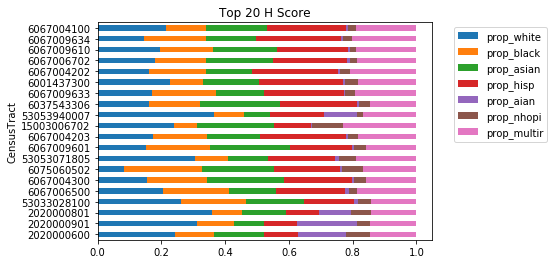

In [24]:
# create top 20 and bottom 20 dfs by entropy 
top_20 = df_dc[['prop_white', 'prop_black', 'prop_asian', 'prop_hisp', 'prop_aian', 'prop_nhopi', 'prop_multir', 'CensusTract']].head(20)

print(top_20)

# plot a Stacked Bar Chart using matplotlib 
top_20.plot( 
    x = 'CensusTract', 
    kind = 'barh', 
    stacked = True, 
    title = 'Top 20 H Score', 
    mark_right = True) 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

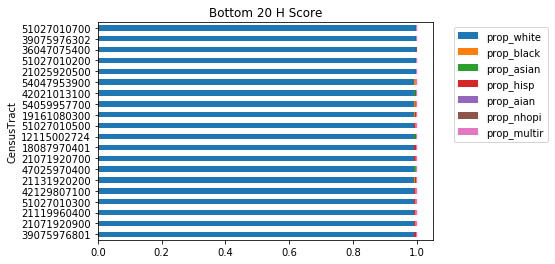

In [37]:
# create bottom 20 df by entropy index
bottom_20 = df_dc[['prop_white', 'prop_black', 'prop_asian', 'prop_hisp', 'prop_aian', 'prop_nhopi', 'prop_multir', 'CensusTract']].tail(20)

# plot a Stacked Bar Chart using matplotlib 
bottom_20.plot( 
    x = 'CensusTract', 
    kind = 'barh', 
    stacked = True, 
    title = 'Bottom 20 H Score', 
    mark_right = True) 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Conclusion: 2010 entropy index are validated based on previous findings for DC.  

### 2010 Checks

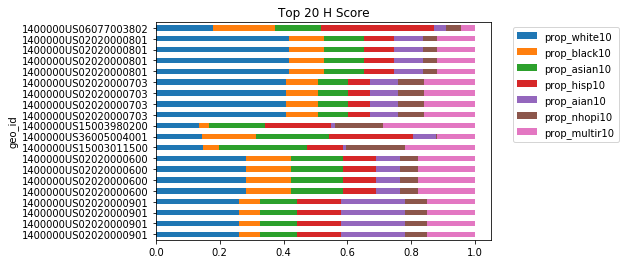

In [26]:
# create top 20 and bottom 20 dfs by entropy 
top_10 = upd_sorted[['geo_id','prop_white10', 'prop_black10', 'prop_asian10', 'prop_hisp10', 'prop_aian10', 'prop_nhopi10', 'prop_multir10']].head(20)


# plot a Stacked Bar Chart using matplotlib 
top_10.plot( 
    x = 'geo_id', 
    kind = 'barh', 
    stacked = True, 
    title = 'Top 20 H Score', 
    mark_right = True) 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

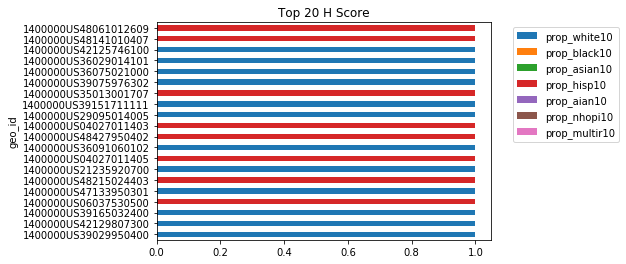

In [38]:
# create top 20 and bottom 20 dfs by entropy 
bottom_10 = upd_sorted[['geo_id','prop_white10', 'prop_black10', 'prop_asian10', 'prop_hisp10', 'prop_aian10', 'prop_nhopi10', 'prop_multir10']].tail(20)


# plot a Stacked Bar Chart using matplotlib 
bottom_10.plot( 
    x = 'geo_id', 
    kind = 'barh', 
    stacked = True, 
    title = 'Top 20 H Score', 
    mark_right = True) 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Part 4: Creating into one dataset for export

Goal: have one file with census tract, state, geo_id, entropy index for 2010 and entropy index for 2019 

In [28]:
# combine 2010 USDA data with 2010 census data
df10_combined = df10b.merge(upd_sorted, how = 'inner', left_on = 'CensusTract', right_on = 'census_tract')

# first 5 obs
df10_combined.head()
#list(df10_combined.columns)

,CensusTract,State,County,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,Urban,Rural,LA1and10,...,race_multi3_y,totalpop10,prop_white10,prop_black10,prop_asian10,prop_hisp10,prop_nhopi10,prop_aian10,prop_multir10,entropy_index10
0,2013000100,AK,Aleutians East,1,1,1,1,0,1,1,...,151,3701,0.057012,0.102405,0.522561,0.154823,0.005944,0.116455,0.04080,1.436035
1,2013000100,AK,Aleutians East,1,1,1,1,0,1,1,...,151,3701,0.057012,0.102405,0.522561,0.154823,0.005944,0.116455,0.04080,1.436035
2,2013000100,AK,Aleutians East,1,1,1,1,0,1,1,...,151,3701,0.057012,0.102405,0.522561,0.154823,0.005944,0.116455,0.04080,1.436035
3,2013000100,AK,Aleutians East,1,1,1,1,0,1,1,...,151,3701,0.057012,0.102405,0.522561,0.154823,0.005944,0.116455,0.04080,1.436035
4,2016000100,AK,Aleutians West,1,1,1,1,0,1,1,...,65,1774,0.349493,0.182074,0.182638,0.007328,0.065389,0.176437,0.03664,1.629681


In [29]:
# create df with censustract as indexes 
df_2015 = df_sorted[['HUNVFlag', 'LILATracts_1And10', 'LILATracts_halfAnd10', 'LILATracts_Vehicle',
                     'LILATracts_1And20', 'LATracts1', 'LATracts10', 'LATracts20', 'LATracts_half', 'entropy_index15', 'CensusTract']].set_index('CensusTract')
#.add_suffix('2015')
df_2010 = df10_combined[['HUNVFlag', 'LILATracts_1And10', 'LILATracts_halfAnd10', 'LILATracts_Vehicle','LILATracts_1And20', 'LATracts1', 
                         'LATracts10', 'LATracts20', 'LATracts_half', 'entropy_index10', 'CensusTract']].set_index('CensusTract')

# merge both dataframes based on census tract (index)
df_combined = pd.merge(df_2015, df_2010, how='inner', left_index=True, right_index=True)

# get shape 
df_combined.shape

# see first 5 obs 
df_combined.head()

,HUNVFlag_x,LILATracts_1And10_x,LILATracts_halfAnd10_x,LILATracts_Vehicle_x,LILATracts_1And20_x,LATracts1_x,LATracts10_x,LATracts20_x,LATracts_half_x,entropy_index15,HUNVFlag_y,LILATracts_1And10_y,LILATracts_halfAnd10_y,LILATracts_Vehicle_y,LILATracts_1And20_y,LATracts1_y,LATracts10_y,LATracts20_y,LATracts_half_y,entropy_index10
CensusTract,,,,,,,,,,,,,,,,,,,,
2013000100,1,1,1,1,1,0,1,1,0,1.648337,1,1,1,1,1,1,1,1,1,1.436035
2013000100,1,1,1,1,1,0,1,1,0,1.648337,1,1,1,1,1,1,1,1,1,1.436035
2013000100,1,1,1,1,1,0,1,1,0,1.648337,1,1,1,1,1,1,1,1,1,1.436035
2013000100,1,1,1,1,1,0,1,1,0,1.648337,1,1,1,1,1,1,1,1,1,1.436035
2016000100,0,1,1,1,1,0,1,1,0,1.430492,0,1,1,1,1,1,1,1,1,1.629681


In [30]:
# subtract the flags for food deserts 
# Results: 1 - 0 = 1 -- a flag in 2015, no in 2010, means appeared in 2015 
# 0 - 1 = -1 -- flag was not in 2015, yes in 2010, means went away in 2015 
# 0 - 0 = 0 -- no change
# 1 - 1 = 0 -- no change 
df1 = df_combined.copy()
df1.columns = df1.columns.str.rsplit('_', n=1, expand=True)
df1 = df1.xs('x', axis=1, level=1).sub(df1.xs('y', axis=1, level=1)).add_suffix('_diff')
df1 = df_combined.join(df1)

# get shape
print(df1.shape)

# 5 obs
df1.head()

(76534, 29)


,HUNVFlag_x,LILATracts_1And10_x,LILATracts_halfAnd10_x,LILATracts_Vehicle_x,LILATracts_1And20_x,LATracts1_x,LATracts10_x,LATracts20_x,LATracts_half_x,entropy_index15,...,entropy_index10,HUNVFlag_diff,LILATracts_1And10_diff,LILATracts_halfAnd10_diff,LILATracts_Vehicle_diff,LILATracts_1And20_diff,LATracts1_diff,LATracts10_diff,LATracts20_diff,LATracts_half_diff
CensusTract,,,,,,,,,,,,,,,,,,,,,
2013000100,1,1,1,1,1,0,1,1,0,1.648337,...,1.436035,0,0,0,0,0,-1,0,0,-1
2013000100,1,1,1,1,1,0,1,1,0,1.648337,...,1.436035,0,0,0,0,0,-1,0,0,-1
2013000100,1,1,1,1,1,0,1,1,0,1.648337,...,1.436035,0,0,0,0,0,-1,0,0,-1
2013000100,1,1,1,1,1,0,1,1,0,1.648337,...,1.436035,0,0,0,0,0,-1,0,0,-1
2013000100,1,1,1,1,1,0,1,1,0,1.648337,...,1.436035,0,0,0,0,0,-1,0,0,-1


In [31]:
df10 = df10_combined.set_index('CensusTract')

In [53]:
no_desert = df1[df1['LILATracts_1And10_diff'] == -1]
no_desert2 = df1[df1['LILATracts_halfAnd10_diff'] == -1]
no_desert3 = df1[df1['LILATracts_Vehicle_diff'] == -1]

# merge with orig df to get state 
ndf_combined = no_desert.merge(df10, how= 'inner', left_index = True, right_index = True)

ndf_combined[['State', 'County', 'LILATracts_1And10_diff']].head()


,State,County,LILATracts_1And10_diff
CensusTract,,,
2020002000,AK,Anchorage,-1
2020002000,AK,Anchorage,-1
2020002000,AK,Anchorage,-1
2020002000,AK,Anchorage,-1
2020002000,AK,Anchorage,-1


In [33]:
dc = ndf_combined[ndf_combined['State'] =='DC']

dc[['LILATracts_1And10_x', 'LILATracts_1And10_y', 'entropy_index15', 'entropy_index10_y']]

,LILATracts_1And10_x,LILATracts_1And10_y,entropy_index15,entropy_index10_y
CensusTract,,,,
11001002102,0,1,1.027944,0.819531
11001007806,0,1,0.355687,0.506627
11001007809,0,1,0.382411,0.072108
11001009501,0,1,1.328890,1.058680
11001009601,0,1,0.263645,0.041900
11001011100,0,1,0.732789,0.615888


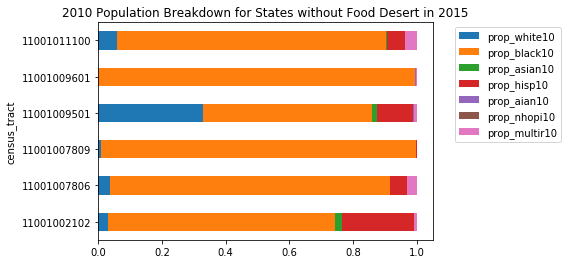

In [48]:
# create top 20 and bottom 20 dfs by entropy 
dc_10 = dc[['census_tract','prop_white10', 'prop_black10', 'prop_asian10', 'prop_hisp10', 'prop_aian10', 'prop_nhopi10', 'prop_multir10']].head(20)


# plot a Stacked Bar Chart using matplotlib 
dc_10.plot( 
    x = 'census_tract', 
    kind = 'barh', 
    stacked = True, 
    title = '2010 Population Breakdown for States without Food Desert in 2015', 
    mark_right = True) 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

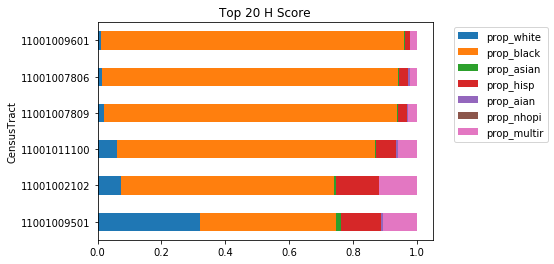

In [47]:
# create top 20 and bottom 20 dfs by entropy 
dc_15a = df_dc[df_dc['CensusTract'].isin(['11001002102', '11001007806', '11001007809',  '11001009501', '11001009601', '11001011100' ])]
dc_15b = dc_15a[['CensusTract','prop_white', 'prop_black', 'prop_asian', 'prop_hisp', 'prop_aian', 'prop_nhopi', 'prop_multir']]


# plot a Stacked Bar Chart using matplotlib 
dc_15b.plot( 
    x = 'CensusTract', 
    kind = 'barh', 
    stacked = True, 
    title = '2015 Population Breakdown for States without Food Desert in 2015', 
    mark_right = True) 

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Final Data Prep to Export

In [74]:
df_f = df_sorted.set_index('CensusTract')

df_f2 = df10_combined.set_index('CensusTract')

In [76]:
# merge df1 with the 2010 demo and usda data
df_a = df1.merge(df_f, how='left', right_index = True, left_index = True)

# merge dfa with the 2015 demo and usda data
df_b = df_a.merge(df_f2, how = 'left', right_index = True, left_index = True)

list(df_b.columns)

['HUNVFlag_x',
 'LILATracts_1And10_x',
 'LILATracts_halfAnd10_x',
 'LILATracts_Vehicle_x',
 'LILATracts_1And20_x',
 'LATracts1_x',
 'LATracts10_x',
 'LATracts20_x',
 'LATracts_half_x',
 'entropy_index15_x',
 'HUNVFlag_y',
 'LILATracts_1And10_y',
 'LILATracts_halfAnd10_y',
 'LILATracts_Vehicle_y',
 'LILATracts_1And20_y',
 'LATracts1_y',
 'LATracts10_y',
 'LATracts20_y',
 'LATracts_half_y',
 'entropy_index10_x',
 'HUNVFlag_diff',
 'LILATracts_1And10_diff',
 'LILATracts_halfAnd10_diff',
 'LILATracts_Vehicle_diff',
 'LILATracts_1And20_diff',
 'LATracts1_diff',
 'LATracts10_diff',
 'LATracts20_diff',
 'LATracts_half_diff',
 'State_x',
 'County_x',
 'Urban_x',
 'POP2010_x',
 'OHU2010_x',
 'GroupQuartersFlag_x',
 'NUMGQTRS_x',
 'PCTGQTRS_x',
 'LILATracts_1And10_x',
 'LILATracts_halfAnd10_x',
 'LILATracts_1And20_x',
 'LILATracts_Vehicle_x',
 'HUNVFlag_x',
 'LowIncomeTracts_x',
 'PovertyRate',
 'MedianFamilyIncome',
 'LA1and10_x',
 'LAhalfand10_x',
 'LA1and20_x',
 'LATracts_half_x',
 'LATracts1

In [77]:
df_b.shape

(120886, 295)

In [78]:
# export to csv
df_b.to_csv('final_usda.csv')